# Run quadratic parameterisation


Parameterisation example is quadratic local with mean Antarctic slope (= no slope dependency) as defined in Burgard et al. (2022).
Based on code initially created by Clara Burgard. Please note that we create the melt rates here, whereas in MeltMIP/ISMIP7 we ask modellers to use their parameterisation implemented in the ice sheet model to produce melt rates for parameter selection.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import multimelt.melt_functions as meltf
from multimelt.constants import *

from parameter_selection_toolbox import *

2026-02-18 14:50:02.063321: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-18 14:50:02.063616: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-18 14:50:02.113377: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-18 14:50:03.546254: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

# Settings

In [3]:
# Directories
figure_dir = 'figures'
data_path="/media/NAS2/ISMIP7/share_with_modellers"
ensemble_path="/mnt/FastStore1/quadratic_out"


# Constants
yearlen = 365.14*24*60*60 # seconds per year
ice_density = 918 # kg/m3
reso=8000 # m model resolution used for melt parameterisation [m]

# parameterisation ensemble table 
p1_name = 'K'
p2_name = 'dummy'

quadratic_present_day_ensemble = "ensemble_quadratic"


# Create data 
Note that this would be replaced with running your melt parameterisation. 

In [4]:
# Create parameter array
# Good set of K
#K = xr.DataArray(data=np.arange(0.25e-5,3.025e-4,0.25e-5), dims=['K_dim']).assign_coords({'K_dim': np.arange(0.25e-5,3.025e-4,0.25e-5)}) 

# Simple set of K
K = xr.DataArray(data=np.arange(1.0e-5,3.6e-4,1e-5), dims=['K_dim']).assign_coords({'K_dim': np.arange(1.0e-5,3.6e-4,1e-5)}) 

K

<xarray.DataArray (K_dim: 35)> Size: 280B
array([1.0e-05, 2.0e-05, 3.0e-05, 4.0e-05, 5.0e-05, 6.0e-05, 7.0e-05,
       8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04, 1.2e-04, 1.3e-04, 1.4e-04,
       1.5e-04, 1.6e-04, 1.7e-04, 1.8e-04, 1.9e-04, 2.0e-04, 2.1e-04,
       2.2e-04, 2.3e-04, 2.4e-04, 2.5e-04, 2.6e-04, 2.7e-04, 2.8e-04,
       2.9e-04, 3.0e-04, 3.1e-04, 3.2e-04, 3.3e-04, 3.4e-04, 3.5e-04])
Coordinates:
  * K_dim    (K_dim) float64 280B 1e-05 2e-05 3e-05 ... 0.00033 0.00034 0.00035

In [5]:
# Load climatology
climatology = xr.load_dataset(os.path.join(data_path, "climatology", "zhou_annual_30_sep", "OI_Climatology_ismip8km_60m_tf_extrap.nc"))
salinity = xr.load_dataset(os.path.join(data_path, "climatology", "zhou_annual_30_sep","OI_Climatology_ismip8km_60m_so_extrap.nc"))

# Load BedMap3
bed = xr.load_dataset(os.path.join(data_path, "topography", "bedmap3_ismip_8km.nc"))

# get thermal forcing at the ice shelf draft
tf_draft = climatology.tf.sel(z=bed['draft'], method='nearest')
tf_draft = tf_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

so_draft = salinity.so.sel(z=bed['draft'], method='nearest')
#so_draft = so_draft.where(so_draft>0, 0) # remove negative values
S0 = so_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

U_factor = (c_po / L_i) * beta_coeff_lazero * (g/(2*abs(f_coriolis))) * S0

In [6]:
model_runs = [] 
p1s = []
p2s = []


for i,k in enumerate(K):

    p1s.append(k)
    p2s.append(1) 
    
    thermal_forcing = (tf_draft).where(bed.floating_frac>0.5, np.nan)        
    ds = meltf.quadratic_mixed_slope(k, melt_factor, thermal_forcing, thermal_forcing, U_factor, np.arcsin(2.9e-3))*yearinsec
    #ds.to_netcdf(os.path.join(ensemble_path,"pd_zhou_"+str(i)+".nc")) 
    #ds = ds.assign_coords(p1=k)
    model_runs.append(ds)

print('Combining datasets')
pd_ensemble = xr.concat(model_runs, dim='K_dim')

pd_ensemble = pd_ensemble.rename({'K_dim':'p1'})
pd_ensemble = pd_ensemble.expand_dims({"p2": np.ones(pd_ensemble.sizes['p1'])})

Combining datasets


In [7]:
# same for Mathiot cold and warm data 

def apply_ocean_modelling_melt(dataset):
    ocean_modelling_data = xr.load_dataset(os.path.join(data_path,"parameterisations", "Ocean_Modelling_Data",dataset+"TF.nc"))

    # get thermal forcing at the ice shelf draft
    tf_draft_om = ocean_modelling_data.thermal_forcing.sel(z=bed['draft'], method='nearest')
    tf_draft_om = tf_draft_om.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

    ocean_modelling_data = xr.load_dataset(os.path.join(data_path,"parameterisations", "Ocean_Modelling_Data",dataset+"S.nc"))
    # get thermal forcing at the ice shelf draft
    so_draft = salinity.so.sel(z=bed['draft'], method='nearest')
    S0 = so_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves
    
    U_factor = (c_po / L_i) * beta_coeff_lazero * (g/(2*abs(f_coriolis))) * S0

    model_runs = []
    for i,k in enumerate(K):
        thermal_forcing = (tf_draft_om).where(bed.floating_frac>0.5, np.nan)        
        ds = meltf.quadratic_mixed_slope(k, melt_factor, thermal_forcing, thermal_forcing, U_factor, np.arcsin(2.9e-3))*yearinsec
        model_runs.append(ds)

    print('Combining datasets')
    
    ensemble = xr.concat(model_runs, dim='K_dim')
    #print(ensemble)
    ensemble = ensemble.rename({'K_dim':'p1'})
    ensemble = ensemble.expand_dims({"p2": np.ones(pd_ensemble.sizes['p1'])})
    return ensemble


# create ensemble for Mathiot data 

mathiot_cold_ensemble = apply_ocean_modelling_melt("Mathiot23_cold_clean_")
mathiot_warm_ensemble = apply_ocean_modelling_melt("Mathiot23_warm_clean_")


Combining datasets
Combining datasets


In [8]:
pd_ensemble.name = "melt_rate"
pd_ensemble = pd_ensemble.to_dataset()

mathiot_cold_ensemble.name = "melt_rate"
mathiot_cold_ensemble = mathiot_cold_ensemble.to_dataset()

mathiot_warm_ensemble.name = "melt_rate"
mathiot_warm_ensemble = mathiot_warm_ensemble.to_dataset()

# Load modellers provided data

In [9]:
## Load ensembles#
#
#quadratic_present_day_ensemble = "pd_zhou"
#quadratic_mathiot_cold_ensemble = "Mathiot23_cold"
#quadratic_mathiot_warm_ensemble = "Mathiot23_warm"
#
#pd_ensemble = xr.load_dataset('Ensemble_'+quadratic_present_day_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
#mathiot_cold_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_cold_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
#mathiot_warm_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_warm_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])

# Load data for optimisation

In [10]:
# Load imbie2 basins as used on ISMIP
basins = xr.load_dataset(os.path.join(data_path, 'imbie2', "basin_numbers_ismip8km.nc"))
basins = basins.rename({'basinNumber':'basins'}) # basins start at 0

nBasins = int(basins.basins.max())

# present-day melting, melt rates from Paolo et al., 2023, error estimates combined from Paolo and Adusumilli et al., 2020
melt_obs = xr.load_dataset(os.path.join(data_path, 'parameterisations','melt_paolo_err_adusumilli_ismip8km.nc')) # Field
MeltDataImbie = pd.read_csv(os.path.join(data_path, 'parameterisations','Melt_Paolo_Err_Adusumilli_imbie2.csv'), index_col=0) # Aggregated per imbier basin

# Buttressing Flux Response Numbers, remapped to 8km 
bfrn = xr.load_dataset(os.path.join(data_path, 'parameterisations',"BFRN_ismip8km_v2.nc"))
nBins = 10

In [11]:
# Load BedMap3
bed = xr.load_dataset(os.path.join(data_path, "topography", "bedmap3_ismip_8km.nc"))
mask = bed.floating_frac>0.5

# Sample

In [12]:
from parameter_selection_toolbox import *

In [91]:
sample_size=10000

optimise ="all" # "term1", ..
term2_spec="average" # "average" # "aggregate"
term3_spec="average" # "average", "aggregate"
term3_opt="anomaly" # "both", "anomaly"
w3_spec="none" # "only_cold", "only_warm", works only with "both"
w3_only_basin= "false" #"false" # 9 for ASE, otherwise put "false" 
average_as="true" # no big effect, can be "true" or "false"


min_p1, min_p2, a1,a2,a3 = calculate_objective_function(optimise,term2_spec,term3_spec,term3_opt, w3_spec,w3_only_basin,
    sample_size, average_as,
    basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
    pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)


Calculate Term 1
Calculate Term 2
Calculate Term 3
Sampling, this might take a moment...


# Analyse K distribution

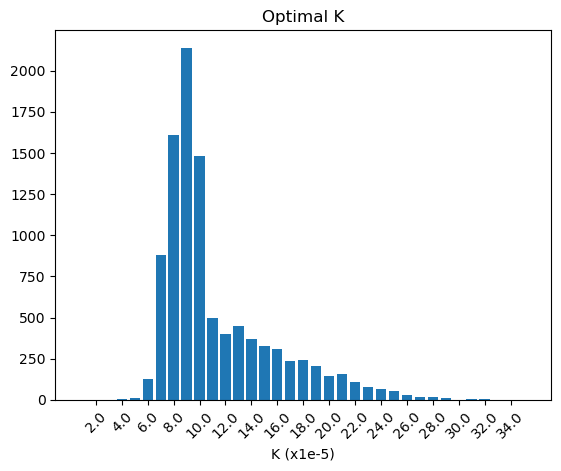

In [92]:
fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

bin_edges = np.array( np.append(pd_ensemble.p1.values[0]*0.5, pd_ensemble.p1.values+1e-7) )
counts, bins = np.histogram(np.array(min_p1), bins= bin_edges)
positions = np.arange(len(pd_ensemble.p1.values))
ax.bar(positions, counts, width=0.8)
labels = np.round(pd_ensemble.p1.values*1e5, 1)
ax.set_xticks(positions[1::2], labels[1::2], rotation=45)
ax.set_xlabel('K (x1e-5)')
ax.set_title('Optimal K')

#plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_sample'+str(sample_size)+'_'+optimise+'as.png'))  
plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_sample'+str(sample_size)+'_'+optimise+'.png'))  

In [93]:
# Find min, max, 5th, 95th, and modes

print('min = ', np.min(np.array(min_p1)))
print('1st = ', np.percentile(np.array(min_p1), 1))
print('5th = ', np.percentile(np.array(min_p1), 5))
print('median = ', np.median(np.array(min_p1)))
print('95th = ', np.percentile(np.array(min_p1), 95))
print('99th = ', np.percentile(np.array(min_p1), 99))
print('max = ', np.max(np.array(min_p1)))

vals = [np.min(np.array(min_p1)), np.percentile(np.array(min_p1), 1), 
        np.percentile(np.array(min_p1), 5), np.median(np.array(min_p1)), 
        np.percentile(np.array(min_p1), 95), np.percentile(np.array(min_p1), 99),
        np.max(np.array(min_p1))
       ]
labs = ['min', '1st', '5th', '50th', '95th', '99th', 'max']

print('mode = ', pd_ensemble.p1.values[np.argmax(counts) ])

# Find local maxima for modes, 
peaks, _ = find_peaks(counts)
modes = pd_ensemble.p1.values[peaks]
print('Modes = ', modes)

min =  3.0000000000000004e-05
1st =  6e-05
5th =  7.000000000000001e-05
median =  0.0001
95th =  0.00021
99th =  0.00025000000000000006
max =  0.00033000000000000005
mode =  9e-05
Modes =  [9.0e-05 1.3e-04 1.8e-04 2.1e-04 3.1e-04]


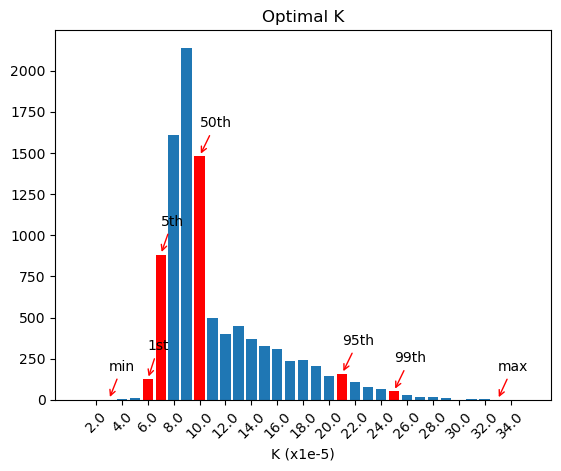

In [94]:
fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

bin_edges = np.array( np.append(pd_ensemble.p1.values[0]*0.5, pd_ensemble.p1.values+1e-7) )
counts, bins = np.histogram(np.array(min_p1), bins= bin_edges)
positions = np.arange(len(pd_ensemble.p1.values))
ax.bar(positions, counts, width=0.8)
#ax.set_ylim([0,350])
for i,val in enumerate(vals):
    bin_index = np.digitize(val, bin_edges) - 1
    ax.patches[bin_index].set_facecolor('red')
    bin_center = bin_index #(bin_edges[bin_index] + bin_edges[bin_index+1]) / 2
    plt.annotate(labs[i], xy=(bin_center, counts[bin_index]), 
                 xytext=(bin_center, counts[bin_index]+175),
                 arrowprops=dict(arrowstyle='->', color='red'))

labels = np.round(pd_ensemble.p1.values*1e5, 1)
ax.set_xticks(positions[1::2], labels[1::2], rotation=45)
ax.set_xlabel('K (x1e-5)')
ax.set_title('Optimal K')


#plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_sample'+str(sample_size)+'_'+optimise+'as_percentiles.png')) 
plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_sample'+str(sample_size)+'_'+optimise+'_percentiles.png'))   


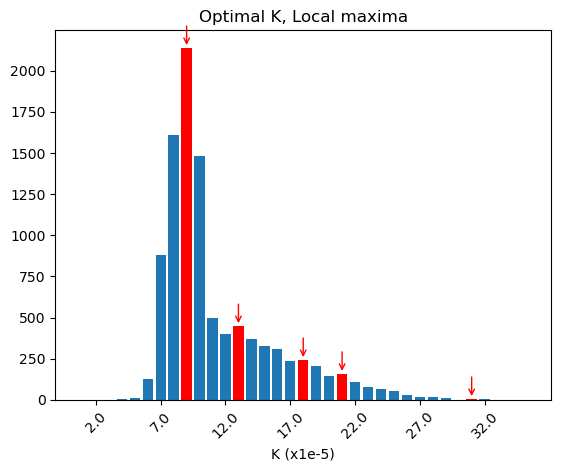

In [95]:
fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes

bin_edges = np.array( np.append(pd_ensemble.p1.values[0]*0.5, pd_ensemble.p1.values+1e-7) )
counts, bins = np.histogram(np.array(min_p1), bins= bin_edges)
positions = np.arange(len(pd_ensemble.p1.values))
ax.bar(positions, counts, width=0.8)
#ax.set_ylim([0,750])

for mode in modes:
    bin_index = np.digitize(mode, bin_edges) - 1 # FIXME this is not working!
    ax.patches[bin_index].set_facecolor('red')
    bin_center = bin_index 
    plt.annotate('', xy=(bin_center, counts[bin_index]), 
                 xytext=(bin_center, counts[bin_index]+150),
                 arrowprops=dict(arrowstyle='->', color='red'))

labels = np.round(pd_ensemble.p1.values*1e5, 1)
ax.set_xticks(positions[1::5], labels[1::5], rotation=45)
ax.set_xlabel('K (x1e-5)')
ax.set_title('Optimal K, Local maxima')


#plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_sample'+str(sample_size)+'_'+optimise+'as_modes.png')) 
plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_sample'+str(sample_size)+'_'+optimise+'_modes.png'))   


In [18]:
counts

array([  0,   0,   0,   1,   0,  14,  87, 160, 198, 156,  64,  42,  56,
        37,  35,  27,  26,  26,  12,  22,  11,   8,   9,   2,   1,   2,
         3,   0,   1,   0,   0,   0,   0,   0,   0])

# Select K value

Select a parameter value from above, e.g., the median or mode, and calculate deltaT to fit present-day, basin-wide melt (basically Term 1).

In [141]:
K = 10e-5

In [142]:
# compare to gT from Jourdain et al., 20220
S0=33
sintheta = 2.9e-3
gT_to_K = 2*abs(f_coriolis)*rho_sw/(rho_i*g*beta_coeff_lazero*S0*sintheta*yearinsec)

print("This corresponds roughly to \gamma_T= ", np.round(K/gT_to_K), "m/a from Jourdain et al., 2020")

This corresponds roughly to \gamma_T=  7419.0 m/a from Jourdain et al., 2020


# Optimise deltaT - optional

First calculate melt rates with the chose K for a range of deltaT corrections (applied uniformly to the whole continent). Note that this should be done within the model parametererisation.

In [143]:
# Create deltaT corrections array
deltaT = np.linspace(-2,3,101) # go up to 3 for melt sensitivity calculation

# calculate melt rates for uniform deltaT 
members = []
for dT in deltaT:      
    thermal_forcing = (tf_draft+dT).where(bed.floating_frac>0.5, np.nan)        
    ds = meltf.quadratic_mixed_slope(K, melt_factor, thermal_forcing, thermal_forcing, U_factor, np.arcsin(2.9e-3))*yearinsec
    ds = ds.assign_coords(deltaT=dT)
    members.append(ds)
dT_ensemble = xr.concat(members, dim='deltaT', coords='minimal')

In [144]:
result_ds = optimise_deltaT(dT_ensemble, basins['basins'], reso, ice_density, MeltDataImbie)
result_ds

<xarray.Dataset> Size: 2MB
Dimensions:                   (y: 761, x: 761, basin: 16)
Coordinates:
  * x                         (x) float64 6kB -3.04e+06 -3.032e+06 ... 3.04e+06
  * y                         (y) float64 6kB -3.04e+06 -3.032e+06 ... 3.04e+06
  * basin                     (basin) int64 128B 0 1 2 3 4 5 ... 11 12 13 14 15
Data variables:
    melt_rate                 (y, x) float32 2MB nan nan nan nan ... nan nan nan
    optimal_deltaT_per_basin  (basin) float64 128B -0.35 -0.35 0.05 ... -0.2 0.1
    sensitivity_per_basin     (basin) float64 128B 1.91 2.11 2.75 ... 1.74 2.51
    residual_per_basin        (basin) float64 128B 1.223 0.0892 ... 2.921 1.494

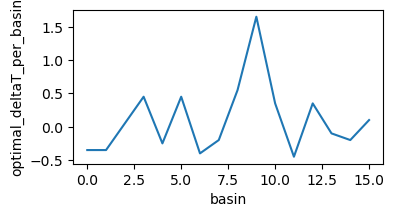

In [145]:
plt.figure(figsize=(4,2))
result_ds.optimal_deltaT_per_basin.plot()

In [146]:
# here we calculate melt rates, using deltaT for the ocean modelling data. This should be done with the melt parameterisation

def apply_deltaT_to_dataset(dataset,optimal_deltaT_per_basin):

    number_of_basins = int(len(optimal_deltaT_per_basin))-1
    ocean_modelling_data = xr.load_dataset(os.path.join(data_path,"parameterisations", "Ocean_Modelling_Data",dataset+"TF.nc"))

    # get thermal forcing at the ice shelf draft
    tf_draft_om = ocean_modelling_data.thermal_forcing.sel(z=bed['draft'], method='nearest')
    tf_draft_om = tf_draft_om.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

    ocean_modelling_data = xr.load_dataset(os.path.join(data_path,"parameterisations", "Ocean_Modelling_Data",dataset+"S.nc"))
    # get thermal forcing at the ice shelf draft
    so_draft = salinity.so.sel(z=bed['draft'], method='nearest')
    S0 = so_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves
    
    U_factor = (c_po / L_i) * beta_coeff_lazero * (g/(2*abs(f_coriolis))) * S0
    
    thermal_forcing = (tf_draft_om).where(bed.floating_frac>0.5, np.nan)  
    
    # Create spatial field from your 1D array
    basins_to_value = xr.DataArray(optimal_deltaT_per_basin, dims=['basins'], coords={'basins': range(number_of_basins+1)})
    spatial_values = basins_to_value.sel(basins=basins['basins'])

    # Add to existing field
    thermal_forcing = thermal_forcing + spatial_values
    ds = meltf.quadratic_mixed_slope(K, melt_factor, thermal_forcing, thermal_forcing, U_factor, np.arcsin(2.9e-3))*yearinsec
    
    return ds

In [147]:
# Apply optimal deltaT also to mathiot data

# create ensemble for Mathiot data 
ensemble_names = ["Mathiot23_cold", "Mathiot23_warm"]
datasets = ["Mathiot23_cold_clean_", "Mathiot23_warm_clean_"]

result_mathiot_cold = apply_deltaT_to_dataset(datasets[0], result_ds.optimal_deltaT_per_basin.values).rename('melt_rate').to_dataset()
result_mathiot_warm = apply_deltaT_to_dataset(datasets[1], result_ds.optimal_deltaT_per_basin.values).rename('melt_rate').to_dataset()


# Create plots

In [148]:
# With optimal deltaT, plot the melt rates, and indvidual terms
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

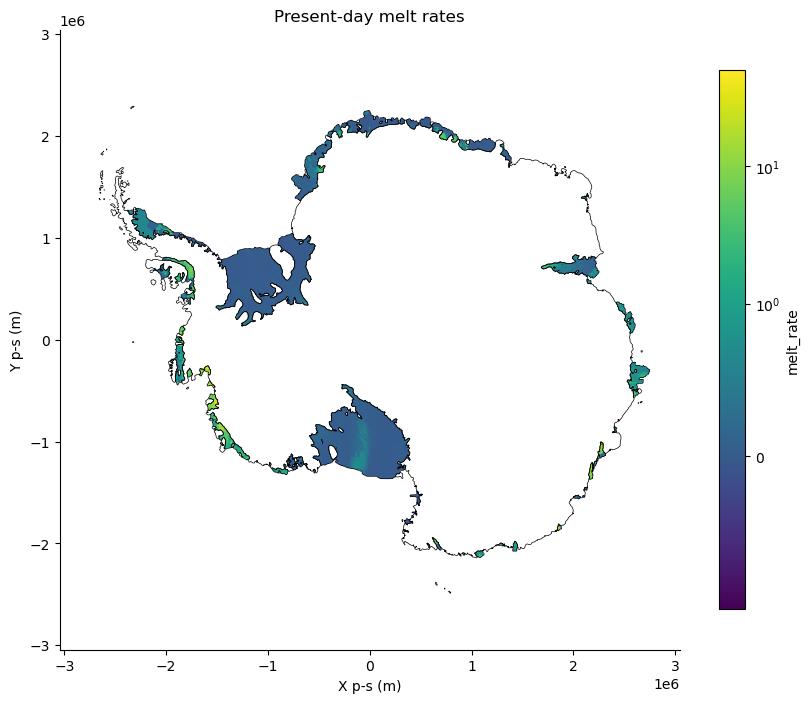

In [149]:
plt.figure(figsize=(10,10))

result_ds.melt_rate.plot( norm=SymLogNorm(linthresh=1, vmin=-1, vmax=50), cmap='viridis',cbar_kwargs={'shrink': 0.7} )
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlabel('X p-s (m)')
ax.set_ylabel('Y p-s (m)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.contour(result_ds.x, result_ds.y, bed.ocean_frac,levels=[0.5], colors=['black'], linewidths=0.5)
plt.contour(result_ds.x, result_ds.y, bed.floating_frac,levels=[0.5], colors=['black'], linewidths=0.5)
plt.title('Present-day melt rates')

plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_K'+str(K)+'_pdmelt.png'))  

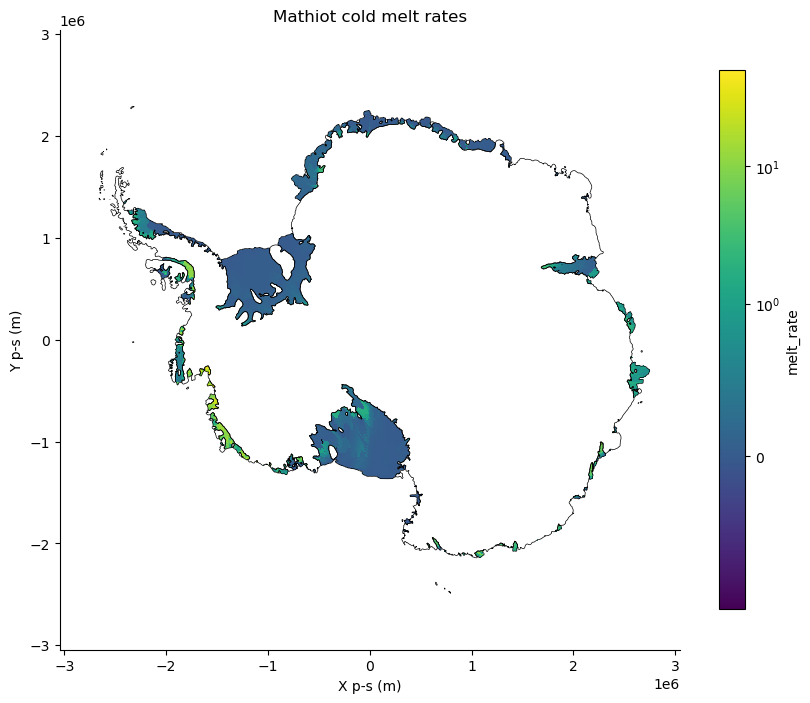

In [150]:
plt.figure(figsize=(10,10))

result_mathiot_cold.melt_rate.plot( norm=SymLogNorm(linthresh=1, vmin=-1, vmax=50), cmap='viridis',cbar_kwargs={'shrink': 0.7} )
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlabel('X p-s (m)')
ax.set_ylabel('Y p-s (m)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.contour(result_ds.x, result_ds.y, bed.ocean_frac,levels=[0.5], colors=['black'], linewidths=0.5)
plt.contour(result_ds.x, result_ds.y, bed.floating_frac,levels=[0.5], colors=['black'], linewidths=0.5)
plt.title('Mathiot cold melt rates')
plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_K'+str(K)+'_mathiotcoldmelt.png'))  

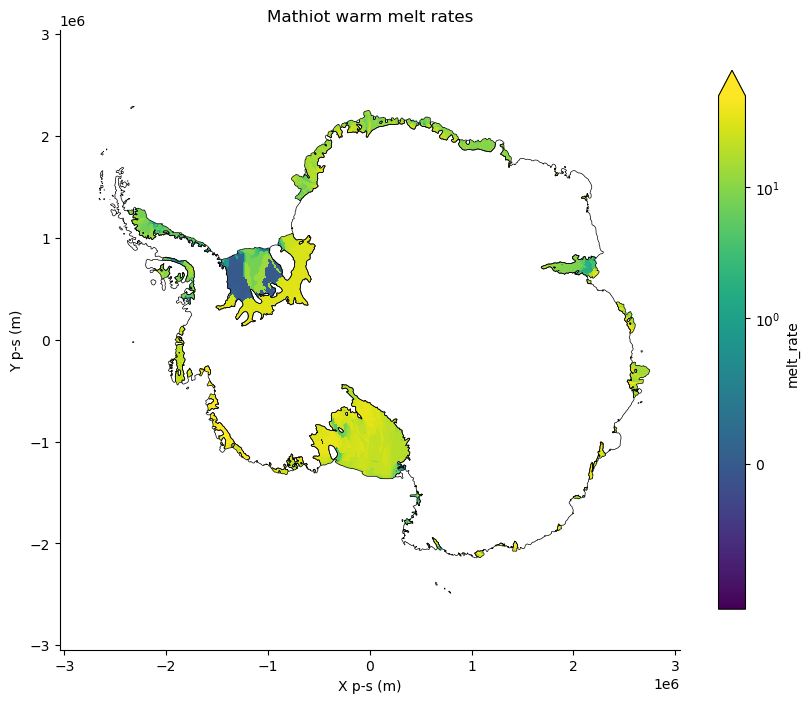

In [151]:
plt.figure(figsize=(10,10))

result_mathiot_warm.melt_rate.plot( norm=SymLogNorm(linthresh=1, vmin=-1, vmax=50), cmap='viridis',cbar_kwargs={'shrink': 0.7} )
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlabel('X p-s (m)')
ax.set_ylabel('Y p-s (m)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.contour(result_ds.x, result_ds.y, bed.ocean_frac,levels=[0.5], colors=['black'], linewidths=0.5)
plt.contour(result_ds.x, result_ds.y, bed.floating_frac,levels=[0.5], colors=['black'], linewidths=0.5)
plt.title('Mathiot warm melt rates')

plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_K'+str(K)+'_mathiotwarmmelt.png'))  

# Plot individual terms

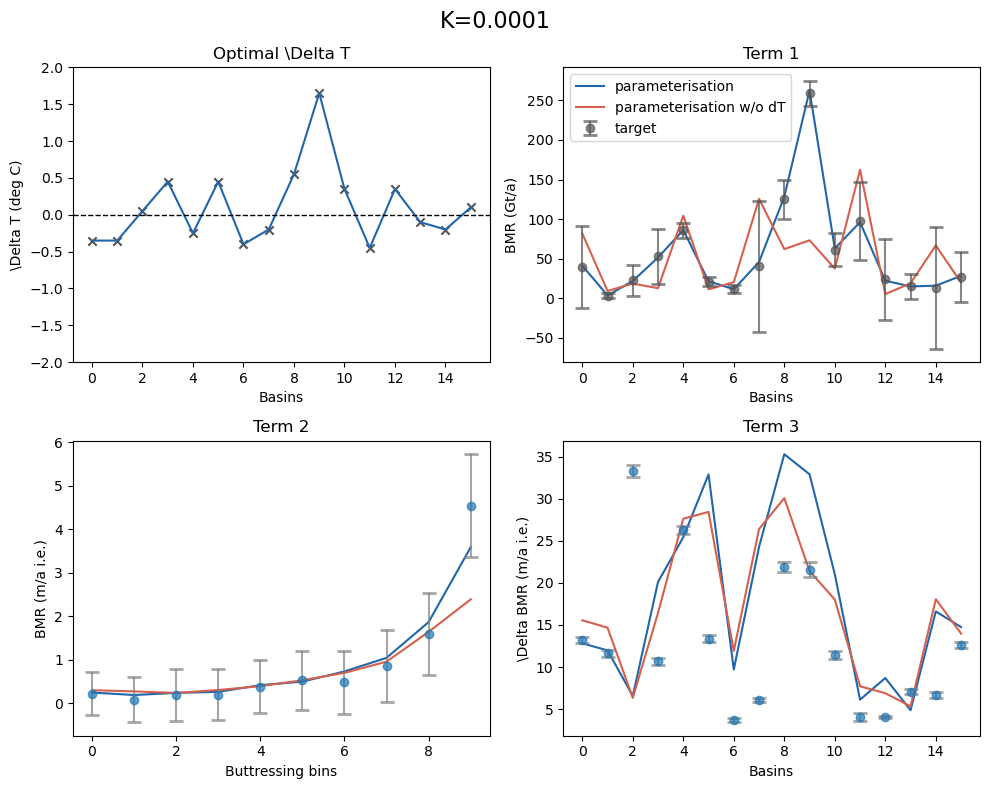

In [152]:
# Basic 2x2 grid

cvt = reso**2 * ice_density / 1e12  # to convert to Gt/a
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

color_deltaT="#2166AC"
color_wocorrection = "#D6604D"
color_wcorrection = "#2166AC"


# Access individual subplots
ax = axes[0, 0]  # Top left
ax.scatter(range(nBasins+1), result_ds.optimal_deltaT_per_basin, color="#555555", marker='x')
ax.plot(range(nBasins+1), result_ds.optimal_deltaT_per_basin, color=color_deltaT)
ax.set_ylim([-2,2])
ax.set_ylabel(r'\Delta T (deg C)')
ax.set_xlabel('Basins')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_title(r'Optimal \Delta T')

ax = axes[0, 1]  # Top right
t1_model_ndT, t1_obs_ndT, t1_obs_mean_ndT, t1_obs_sigma_ndT = calculate_term1(pd_ensemble.sel(p1=K, method='nearest').isel(p2=0),mask,basins['basins'],nBasins,cvt,MeltDataImbie,1)
t1_model, t1_obs, t1_obs_mean, t1_obs_sigma = calculate_term1(result_ds,mask,basins['basins'],nBasins,cvt,MeltDataImbie,1)


ax.plot(range(nBasins+1),t1_model , label='parameterisation', color=color_wcorrection)
ax.plot(range(nBasins+1),t1_model_ndT , label='parameterisation w/o dT', color=color_wocorrection)
ax.errorbar(range(nBasins+1), t1_obs_mean, xerr=None, yerr=t1_obs_sigma, 
             fmt='o', capsize=5, capthick=2, color="#555555", 
             ecolor="#555555", alpha=0.7, label='target')
ax.set_ylabel('BMR (Gt/a)')
ax.set_xlabel('Basins')
#plt.text(0,2, 'Modelled average melt = '+str(np.round(np.sum(t2_model).values))+' m/a' )
#plt.text(0,1, 'Observed average melt = '+str(np.round(np.sum(t2_obs_mean).values))+' m/a' )
ax.legend()
ax.set_title('Term 1')

ax = axes[1, 0]  # Bottom left
t2_model_ndT, t2_obs, t2_weights, t2_obs_mean, t2_obs_sigma = calculate_term2(
    pd_ensemble.sel(p1=K, method='nearest').isel(p2=0),mask,bfrn,cvt,sample_size,term2_spec,ice_density,melt_obs)

t2_model, t2_obs, t2_weights, t2_obs_mean, t2_obs_sigma = calculate_term2(
    result_ds,mask,bfrn,cvt,sample_size,term2_spec,ice_density,melt_obs)

ax.plot(range(nBins),t2_model/ice_density , label='parameterisation', color=color_wcorrection)
ax.plot(range(nBins),t2_model_ndT/ice_density , label='parameterisation w/o dT', color=color_wocorrection)
ax.errorbar(range(nBins), t2_obs_mean/ice_density, xerr=None, yerr=t2_obs_sigma/ice_density, 
             fmt='o', capsize=5, capthick=2,
             ecolor='gray', alpha=0.7, label='target')
ax.set_ylabel('BMR (m/a i.e.)')
ax.set_xlabel('Buttressing bins')
#ax.legend()
ax.set_title('Term 2')


ax = axes[1, 1]  # Bottom right

t3_model_ndT, t3_obs, t3_weights, t3_obs_mean, t3_obs_sigma = calculate_term3(
    pd_ensemble.sel(p1=K, method='nearest').isel(p2=0),mathiot_cold_ensemble.sel(p1=K, method='nearest').isel(p2=0), 
    mathiot_warm_ensemble.sel(p1=K, method='nearest').isel(p2=0),
    mask,basins['basins'],cvt,sample_size,term3_spec,term3_opt,w3_spec,
    ice_density,data_path,nBasins,w3_only_basin)

t3_model, t3_obs, t3_weights, t3_obs_mean, t3_obs_sigma = calculate_term3(
    result_ds,result_mathiot_cold, result_mathiot_warm,
    mask,basins['basins'],cvt,sample_size,term3_spec,term3_opt,w3_spec,
    ice_density,data_path,nBasins,w3_only_basin)



ax.plot(range(nBasins+1),t3_model/ice_density , label='parameterisation', color=color_wcorrection)
ax.plot(range(nBasins+1),t3_model_ndT/ice_density , label='parameterisation w/o dT',color=color_wocorrection)
ax.errorbar(range(nBasins+1), t3_obs_mean/ice_density, xerr=None, yerr=t3_obs_sigma/ice_density, 
             fmt='o', capsize=5, capthick=2,
             ecolor='gray', alpha=0.7, label='target')
ax.set_ylabel('\Delta BMR (m/a i.e.)')
ax.set_xlabel('Basins')
#ax.legend()
ax.set_title('Term 3')

# Add overall title
fig.suptitle('K='+str(K), fontsize=16)


# Adjust spacing
plt.tight_layout()


plt.savefig(os.path.join(figure_dir,'Optimise_quadratic_K'+str(K)+'_Terms.png'))  